# STPB_LSTM_WITH_CLASS

In [826]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [827]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [828]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [829]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [830]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [831]:
from gmt.fom.gas.shared.models.short_term_power_burn.stpb import MongoAdapter

In [832]:
figsize=(9*1.6, 9)

In [833]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [834]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

In [835]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=8, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# CONSTANTS

In [836]:
YEARS = 4

In [837]:
FORECAST_HORIZON = 21; FORECAST_HORIZON

21

In [838]:
INPUT_WIDTH = 150; INPUT_WIDTH 

150

# DATA

In [839]:
myData = MongoAdapter()
data = myData.load_design_matrix()

In [840]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [841]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [842]:
pred_idx = data[-(INPUT_WIDTH):-FORECAST_HORIZON].index

In [843]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [844]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [845]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1462
val_idx=258
pred_idx=129
out_t_idx=21


In [846]:
len(train_idx)/data.shape[0]

0.7818181818181819

In [847]:
len(val_idx)/data.shape[0]

0.13796791443850268

In [848]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [849]:
#Enrich for Design Matrix

In [850]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [851]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [852]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [853]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=False)

In [854]:
train_df = DM.dm.loc[train_idx].drop('y', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('y', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('y', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('y', axis=1).rename(columns=DM.names)

In [855]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std


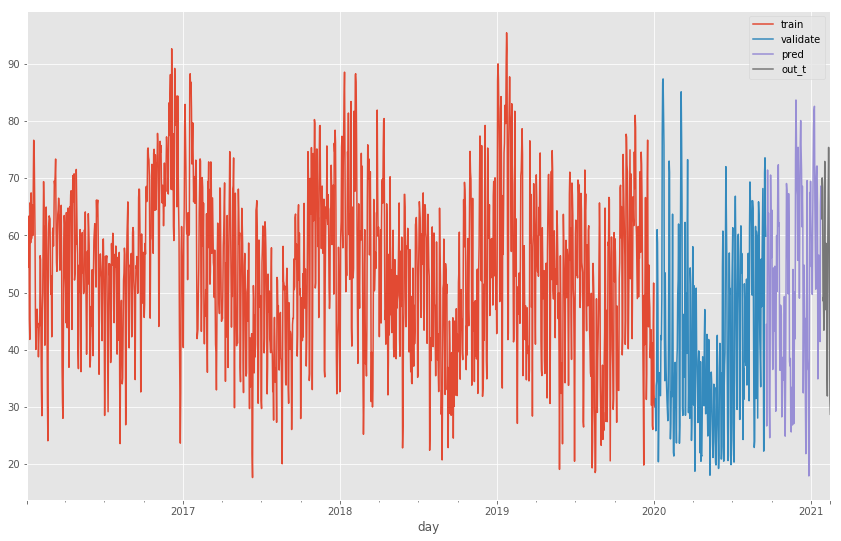

In [856]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'validate', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [857]:
train_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-01-03,-1.697426,-0.271198,-1.159558,-0.518133,-0.679771,0.980831,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


In [858]:
val_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-01-04,-1.599593,-0.271198,-1.159558,-0.764528,-0.753444,0.37391,5.872145e-14,1.415182,1.153151e-13,1.415182,-1.464933e-13,1.415182


In [859]:
val_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-09-17,0.428746,0.201656,-0.689099,-0.887726,0.951421,-0.455264,-1.377814,-0.313725,0.613185,-1.273196,1.104921,0.882715


In [860]:
pred_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-09-18,-0.671591,0.201656,-0.689099,-0.873511,0.74457,-0.233011,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


In [861]:
pred_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2021-01-24,0.748126,0.917313,1.186721,-0.119874,-2.117808,-0.97072,1.104921,0.882715,1.377814,-0.313725,0.613185,-1.273196


In [862]:
out_df

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2021-01-25,62.916814,4.512710,2.827994,0.571333,1.735000,3.870,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,-7.818315e-01,0.623490
2021-01-26,70.075214,12.090070,7.583764,4.017333,2.338636,2.880,4.338837e-01,-0.900969,-7.818315e-01,0.623490,9.749279e-01,-0.222521
2021-01-27,68.325320,15.709930,8.431819,6.396667,5.783636,2.267,-4.338837e-01,-0.900969,7.818315e-01,0.623490,-9.749279e-01,-0.222521
2021-01-28,48.563767,3.545882,-4.120809,11.934667,7.134545,3.709,-9.749279e-01,-0.222521,4.338837e-01,-0.900969,7.818315e-01,0.623490
2021-01-29,49.212921,3.545882,-4.120809,4.544667,6.521818,5.042,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,-4.338837e-01,-0.900969
2021-01-30,43.433359,3.545882,-4.120809,4.155333,3.523182,5.905,-2.937914e-14,1.000000,-5.875829e-14,1.000000,-5.428848e-13,1.000000
2021-01-31,56.874554,3.846751,-3.236222,3.189333,1.575000,3.468,7.818315e-01,0.623490,9.749279e-01,-0.222521,4.338837e-01,-0.900969
2021-02-01,72.962440,27.828463,21.946149,3.745333,2.615455,2.817,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,-7.818315e-01,0.623490
2021-02-02,47.010701,5.487781,-6.284400,7.919333,5.053182,5.686,4.338837e-01,-0.900969,-7.818315e-01,0.623490,9.749279e-01,-0.222521


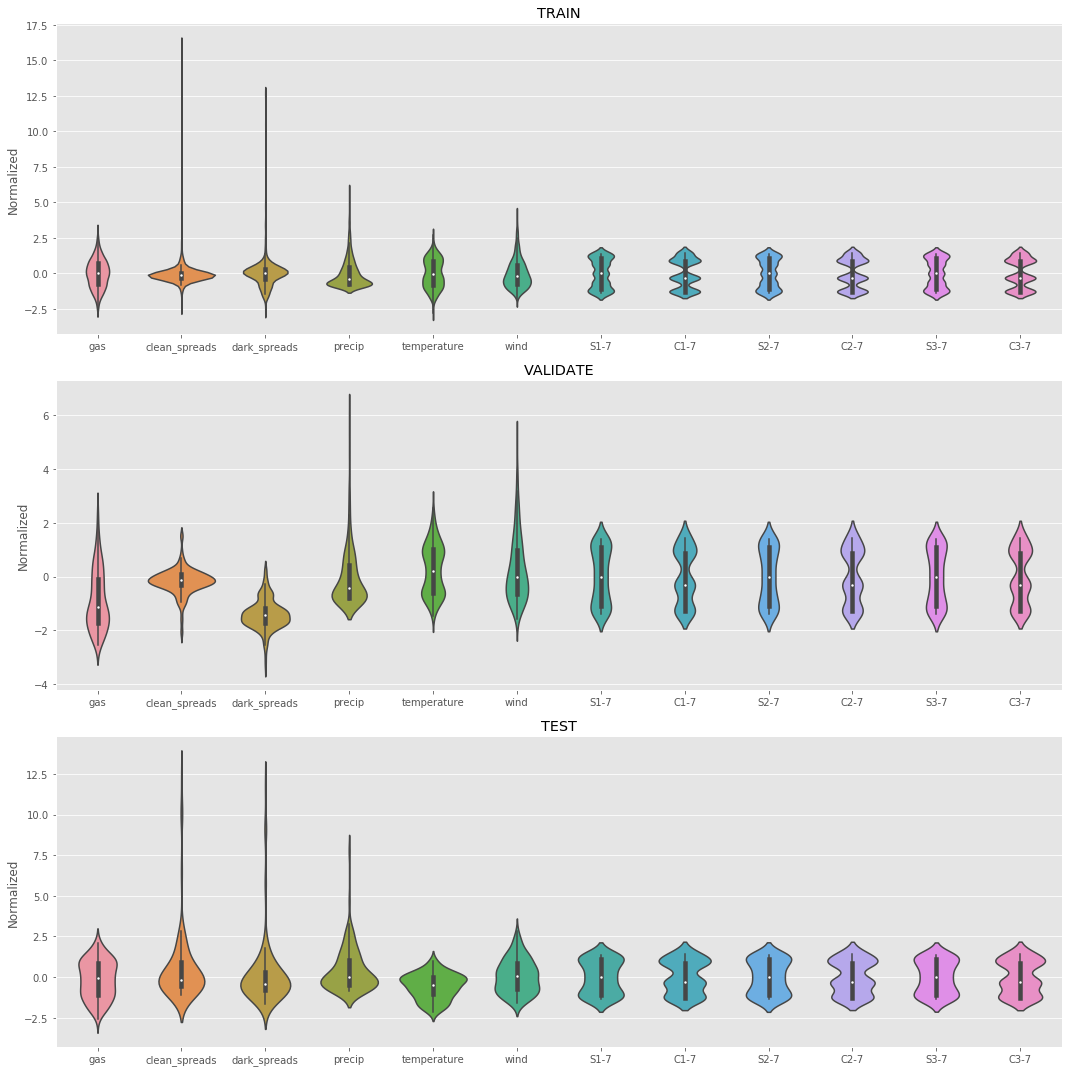

In [863]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
_ = val_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
ax2.set_title('VALIDATE')
ax3.set_title('TEST')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

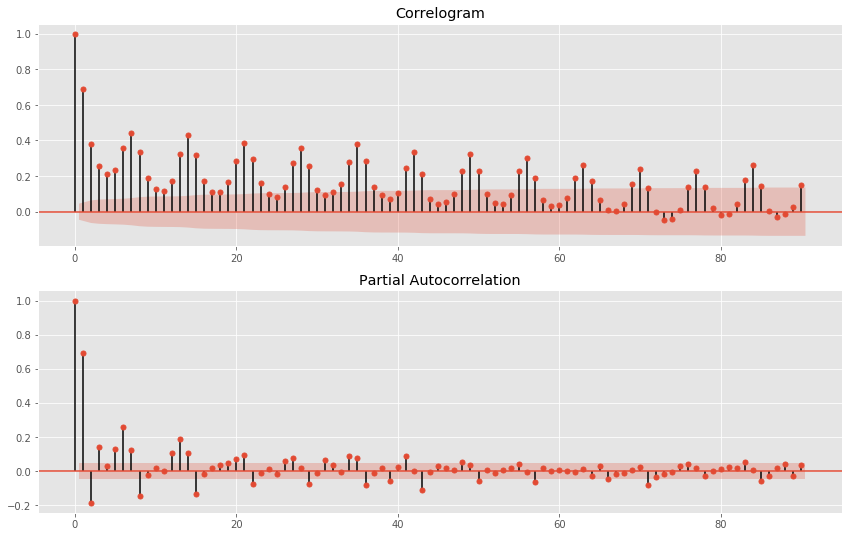

In [864]:
stb.stat_plots.plot_acf_pcf(DM.y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

# WINDOWS GENERATOR

In [865]:
INP_W = 7*3
OUT_W = 7*3
BATC_S = 32
SHUFFLE = True

print(f'INP_W={INP_W} OUT_W={OUT_W} BATC_S={BATC_S} SHUFFLE={SHUFFLE}')

INP_W=21 OUT_W=21 BATC_S=32 SHUFFLE=True


In [866]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=pred_df,
                         label_columns=['gas'])

In [867]:
window

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label column name(s): ['gas']

In [868]:
window.config(shuffle=SHUFFLE, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': True, 'batch_size': 32}


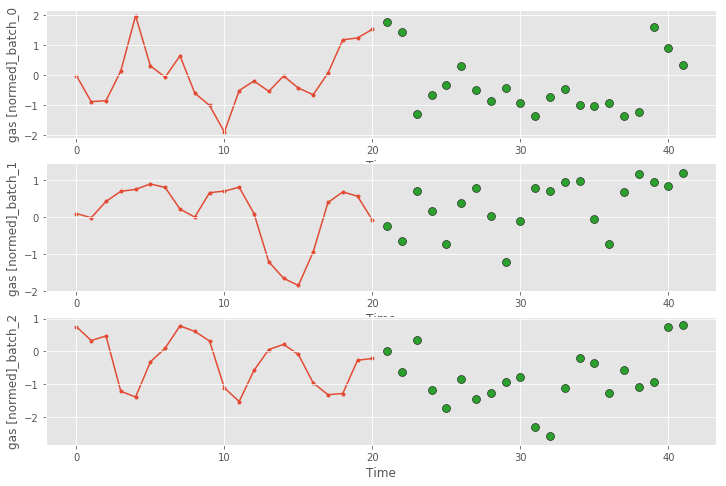

In [869]:
window.plot('gas')

# Long Short Term Memory RNN with FEEDBACK

In [870]:
num_features = train_df.shape[1]

In [871]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
      super().__init__()
      self.out_steps = out_steps
      self.units = units
      self.lstm_cell = tf.keras.layers.LSTMCell(units)
      # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
      self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
      self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
      # inputs.shape => (batch, time, features)
      # x.shape => (batch, lstm_units)
      x, *state = self.lstm_rnn(inputs)

      # predictions.shape => (batch, features)
      prediction = self.dense(x)
      return prediction, state

    def call(self, inputs, training=None):
       # Use a TensorArray to capture dynamically unrolled outputs.
       predictions = []
       # Initialize the lstm state
       prediction, state = self.warmup(inputs)

       # Insert the first prediction
       predictions.append(prediction)

       # Run the rest of the prediction steps
       for n in range(1, self.out_steps):
         # Use the last prediction as input.
         x = prediction
         # Execute one lstm step.
         x, state = self.lstm_cell(x, states=state,
                                       training=training)
         # Convert the lstm output to a prediction.
         prediction = self.dense(x)
         # Add the prediction to the output
         predictions.append(prediction)

       # predictions.shape => (time, batch, features)
       predictions = tf.stack(predictions)
       # predictions.shape => (batch, time, features)
       predictions = tf.transpose(predictions, [1, 0, 2])
       return predictions


In [872]:
feedback_model = FeedBack(units=BATC_S, out_steps=OUT_W)

In [873]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', feedback_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (32, 21, 12)
Output shape (batch_size, output_days): (32, 21, 12)


In [874]:
history = compile_and_fit(feedback_model,window)

Epoch 1/200
45/45 [==============================] - 4s 20ms/step - loss: 0.9189 - mean_squared_error: 0.9189 - val_loss: 1.6765 - val_mean_squared_error: 1.6765
Epoch 2/200
45/45 [==============================] - 0s 9ms/step - loss: 0.8396 - mean_squared_error: 0.8396 - val_loss: 1.8262 - val_mean_squared_error: 1.8262
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 0.7622 - mean_squared_error: 0.7622 - val_loss: 1.7911 - val_mean_squared_error: 1.7911
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 0.7214 - mean_squared_error: 0.7214 - val_loss: 1.7753 - val_mean_squared_error: 1.7753
Epoch 5/200
45/45 [==============================] - 0s 9ms/step - loss: 0.7218 - mean_squared_error: 0.7218 - val_loss: 1.7792 - val_mean_squared_error: 1.7792
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 0.6957 - mean_squared_error: 0.6957 - val_loss: 1.5558 - val_mean_squared_error: 1.5558
Epoch 7/200
45/45 [==============

45/45 [==============================] - 1s 11ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - val_loss: 2.0629 - val_mean_squared_error: 2.0629
Epoch 102/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1044 - mean_squared_error: 0.1044 - val_loss: 1.9206 - val_mean_squared_error: 1.9206
Epoch 103/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - val_loss: 1.9355 - val_mean_squared_error: 1.9355
Epoch 104/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 2.0482 - val_mean_squared_error: 2.0482
Epoch 105/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1127 - mean_squared_error: 0.1127 - val_loss: 2.0818 - val_mean_squared_error: 2.0818
Epoch 106/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 1.9669 - val_mean_squared_error: 1.9669
Epoch 107/200
45/45 [=========

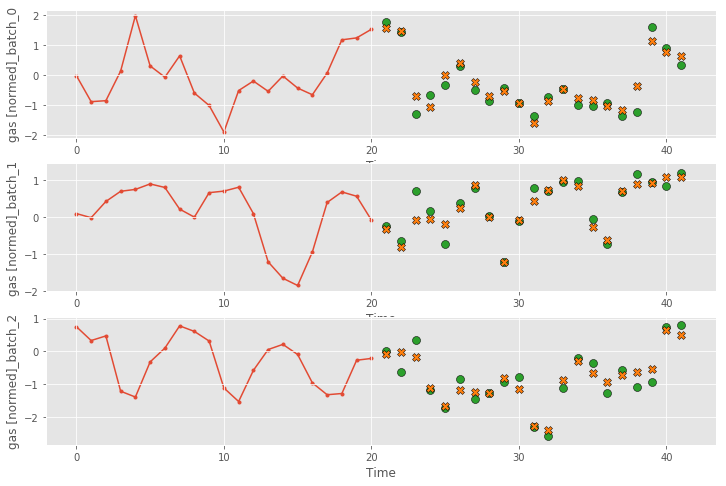

In [875]:
res = window.plot('gas', model=feedback_model, feedback=True)

In [876]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [877]:
fl = stb.utils.common.flatten_lst

In [878]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29'],
              dtype='datetime64[ns]', name='day', freq=None)

In [879]:
tf.transpose(feedback_model.predict(w_pred.train), [0,2,1])[0,0,:]

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([ 0.5495421 , -1.0205549 , -1.4016784 ,  0.12295952,  0.5197358 ,
        0.08259867,  0.27872014,  0.6232111 ,  0.23781092,  0.7403078 ,
        1.4014592 ,  1.3185779 ,  0.83621186,  0.39724612, -0.11695983,
       -0.9221958 , -0.40487987,  1.0287236 ,  0.22412497, -0.68925184,
       -0.6488282 ], dtype=float32)>

In [880]:
predicted = tf.transpose(feedback_model.predict(w_pred.train), [0,2,1])[0,0,:]

In [881]:
v_hat = pd.Series(predicted, index=idx); 

In [882]:
v = pred_df.loc[idx]['gas']; 

In [883]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; 

In [884]:
y = DM.dm.loc[y_hat.index]['y']; 

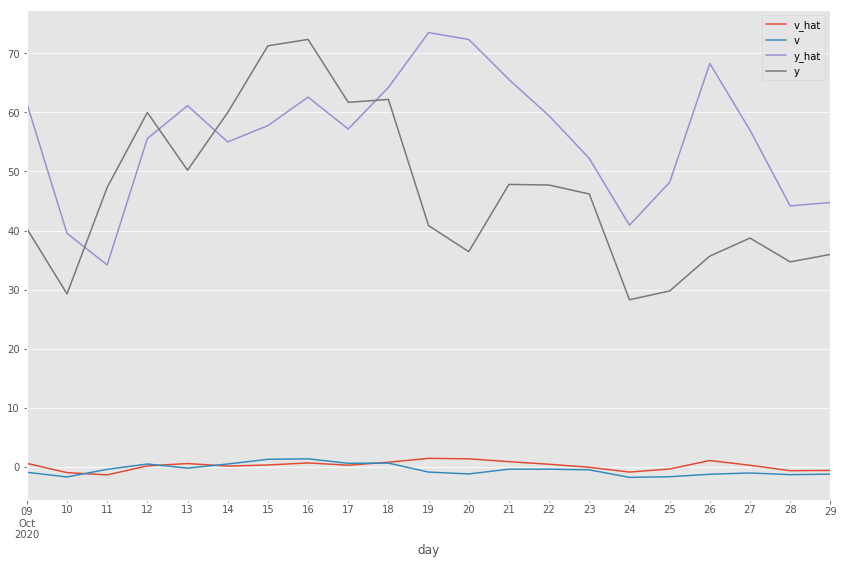

In [885]:
stb.utils.dframe.concat_columnwise(v_hat.rename('v_hat'),v.rename('v'),y_hat.rename('y_hat'),y.rename('y')).plot(figsize=figsize)

In [886]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=17.0598


In [887]:
metric = stb.metrics.root_mean_squared_error

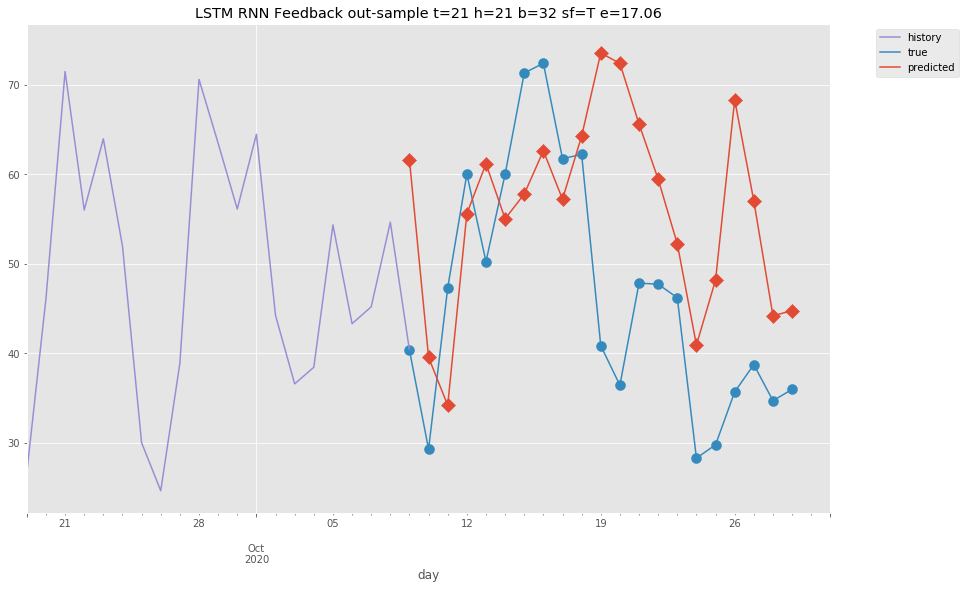

In [888]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(INP_W):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN Feedback out-sample t={OUT_W} h={INP_W} b={BATC_S} sf={str(SHUFFLE)[0]} e={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()